In [1]:
import pandas as pd
import numpy as np
from preprocessing import get_preprocessor, get_preprocessor_poly
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import set_config
import matplotlib.pyplot as plt
import seaborn as sns
set_config(transform_output="pandas")

In [2]:
df = pd.read_csv("https://storage.googleapis.com/second-try-ml/air-pollution/Train.csv")
df.head(2)

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,...,L3_HCHO_cloud_fraction,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.0,60.200001,0.00804,18.516840,1.996377,-1.227395,0.000074,0.000156,-1.231330,0.006507,840209.874619,76.537512,38.634284,-61.736719,22.358167,0.000057,6156.074219,0.000017,0.119095,234.151102,0.000000,76.536426,38.593017,-61.752587,22.363665,0.021080,883.332451,267.017184,840138.461052,74.543393,38.622451,-61.789016,...,0.000000,76.536426,38.593017,-61.752587,22.363665,0.000064,0.566828,NaN,NaN,0.000000,NaN,NaN,NaN,76.536426,38.593017,-61.752587,22.363665,NaN,-1.231330,840209.874619,76.537512,38.634284,-61.736719,22.358167,-0.000127,0.312521,-0.00004,-1.861476,0.000000,76.536426,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.6,48.799999,0.00839,22.546533,3.330430,-1.188108,0.000076,0.000197,-1.082553,0.018360,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000055,6156.074219,0.000021,0.115179,233.313706,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.022017,1148.985447,61.216687,841116.763051,-57.015200,61.402626,-74.457583,...,0.059433,-14.708036,59.624912,-67.693509,28.614804,0.000171,0.858446,175.019862,99354.162958,0.059358,5.958538,175.072145,99353.672374,-14.708036,59.624912,-67.693509,28.614804,0.315403,-1.082553,840772.941995,-14.708036,59.624912,-67.693509,28.614804,0.000150,0.433957,0.00005,-1.452612,0.059433,-14.708036,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652


In [3]:
RSEED = 42
X = df.drop("target", axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True, random_state=RSEED)
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head(2)

,Place_ID X Date,Date,Place_ID,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_NO2_NO2_column_number_density,L3_NO2_NO2_slant_column_number_density,L3_NO2_absorbing_aerosol_index,L3_NO2_cloud_fraction,L3_NO2_sensor_altitude,L3_NO2_sensor_azimuth_angle,L3_NO2_sensor_zenith_angle,L3_NO2_solar_azimuth_angle,L3_NO2_solar_zenith_angle,L3_NO2_stratospheric_NO2_column_number_density,L3_NO2_tropopause_pressure,L3_NO2_tropospheric_NO2_column_number_density,L3_O3_O3_column_number_density,L3_O3_O3_effective_temperature,L3_O3_cloud_fraction,L3_O3_sensor_azimuth_angle,L3_O3_sensor_zenith_angle,L3_O3_solar_azimuth_angle,L3_O3_solar_zenith_angle,L3_CO_CO_column_number_density,L3_CO_H2O_column_number_density,L3_CO_cloud_height,L3_CO_sensor_altitude,L3_CO_sensor_azimuth_angle,L3_CO_sensor_zenith_angle,L3_CO_solar_azimuth_angle,L3_CO_solar_zenith_angle,...,L3_HCHO_sensor_azimuth_angle,L3_HCHO_sensor_zenith_angle,L3_HCHO_solar_azimuth_angle,L3_HCHO_solar_zenith_angle,L3_HCHO_tropospheric_HCHO_column_number_density,L3_HCHO_tropospheric_HCHO_column_number_density_amf,L3_CLOUD_cloud_base_height,L3_CLOUD_cloud_base_pressure,L3_CLOUD_cloud_fraction,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_top_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_sensor_azimuth_angle,L3_CLOUD_sensor_zenith_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle,L3_CLOUD_surface_albedo,L3_AER_AI_absorbing_aerosol_index,L3_AER_AI_sensor_altitude,L3_AER_AI_sensor_azimuth_angle,L3_AER_AI_sensor_zenith_angle,L3_AER_AI_solar_azimuth_angle,L3_AER_AI_solar_zenith_angle,L3_SO2_SO2_column_number_density,L3_SO2_SO2_column_number_density_amf,L3_SO2_SO2_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_cloud_fraction,L3_SO2_sensor_azimuth_angle,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle,target
19308,KYNZWCA X 2020-03-10,2020-03-10,KYNZWCA,4.0,61.0,1726.84,61,16.518541,63.600002,0.006580,14.496118,2.062937,0.058535,0.000065,0.000134,-1.751167,0.070823,841923.088754,76.027705,13.218773,-39.126728,41.704754,0.000055,13050.637454,0.000012,0.118775,232.953336,0.084721,76.027705,13.218773,-39.126728,41.704754,0.016463,3083.434834,2410.957586,841874.365897,71.122785,13.257601,-39.138624,41.723925,...,76.027705,13.218773,-39.126728,41.704754,0.000041,0.657139,7694.326466,38979.172638,0.085942,5.458090,8694.326563,33876.847240,76.027705,13.218773,-39.126728,41.704754,0.198105,-1.751164,841923.088754,76.027705,13.218773,-39.126728,41.704754,0.000059,0.330969,0.000017,-2.454729,0.084721,76.027705,13.218773,-39.126728,41.704754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0
7260,7DRFQCK X 2020-03-08,2020-03-08,7DRFQCK,3.0,55.0,2115.89,168,3.186504,57.642859,0.001815,-2.886062,-2.302383,-2.982198,0.000045,0.000185,-1.157417,0.467880,837596.655450,-5.875045,46.167440,42.373135,70.428918,0.000035,22060.528945,0.000012,0.188647,226.097083,0.556788,0.027171,43.072985,52.766501,70.072593,0.037618,210.244586,228.614041,837143.998073,-30.455741,39.632028,-20.734173,69.408800,...,44.216324,33.577577,144.092487,69.127324,0.000060,1.731351,942.470410,88688.796224,0.572691,35.012262,1369.239830,84569.575384,0.027320,43.073638,52.766380,70.073347,0.241965,-1.154776,837689.984794,-2.954586,47.820933,50.666882,70.655203,0.000407,0.395603,0.000192,-2.225702,0.215436,8.937053,36.256971,66.413640,69.282032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0


In [4]:
preproc = get_preprocessor()

In [5]:
# fig, axs = plt.subplots(6,6, figsize=(12,12), sharey=True)
# for i, ax in enumerate(axs.flat):
#     if i==35:   break
#     sns.scatterplot(x=X_train_pp[X_test_pp.columns.tolist()[i]], y=y_train, ax=ax)
#     ax.set_title(X_test_pp.columns.tolist()[i], fontsize=6)
#     ax.set_xlabel("")
#     ax.set_ylabel("")
# fig.tight_layout()

In [121]:
def print_scores(y_train, y_test, y_pred_train, y_pred):
    print("Train RMSE: ", mean_squared_error(y_train, y_pred_train, squared=False))
    print("Train R^2: ", r2_score(y_train, y_pred_train))
    print("Test RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    print("Test R^2: ", r2_score(y_test, y_pred))

In [6]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.4, shuffle=True, random_state=RSEED)

In [123]:
preproc_poly = get_preprocessor_poly()

rid = Pipeline([
    ("preproc", preproc_poly),
    ("ridge", RidgeCV(cv=3)),
    ])

rid.fit(X_train_1, y_train_1)

rid_pred = rid.predict(X_train_2)
rid_pred_train = rid.predict(X_train_1)

print_scores(y_train_1, y_train_2, rid_pred_train, rid_pred)

Train RMSE:  32.067895160464666
Train R^2:  0.5328587049133635
Test RMSE:  35.27355923220966
Test R^2:  0.44102233323214013


In [124]:
knn = Pipeline([
    ("preproc", preproc),
    ("knn", KNeighborsRegressor(n_neighbors=10, weights="distance")),
    ])

knn.fit(X_train_1, y_train_1)

knn_pred = knn.predict(X_train_2)
knn_pred_train = rid.predict(X_train_1)

print_scores(y_train_1, y_train_2, knn_pred_train, knn_pred)

Train RMSE:  32.067895160464666
Train R^2:  0.5328587049133635
Test RMSE:  34.14845771519231
Test R^2:  0.47611245105784006


In [125]:
randF = Pipeline([
    ("preproc", preproc),
    ("randF", RandomForestRegressor(n_estimators=200, max_depth=10, random_state=RSEED, n_jobs=-1)),
    ])

randF.fit(X_train_1, y_train_1)
randF_pred = randF.predict(X_train_2)
randF_pred_train = rid.predict(X_train_1)

print_scores(y_train_1, y_train_2, randF_pred_train, randF_pred)

Train RMSE:  32.067895160464666
Train R^2:  0.5328587049133635
Test RMSE:  34.596993905582686
Test R^2:  0.4622596579376611


In [127]:
df_train_final = pd.concat([pd.DataFrame(rid_pred), pd.DataFrame(knn_pred), pd.DataFrame(randF_pred)], axis=1)
finalForest = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=RSEED, n_jobs=-1)
finalForest.fit(df_train_final, y_train_2)

final_pred_train = finalForest.predict(df_train_final)

rid_pred_test = rid.predict(X_test)
knn_pred_test = knn.predict(X_test)
randF_pred_test = randF.predict(X_test)

comb_pred = pd.concat([
            pd.DataFrame(rid_pred_test), 
            pd.DataFrame(knn_pred_test),
            pd.DataFrame(randF_pred_test),
        ], axis=1)

final_pred = finalForest.predict(comb_pred)

print_scores(y_train_2, y_test, final_pred_train, final_pred)

Train RMSE:  31.93824029266297
Train R^2:  0.5417337677206845
Test RMSE:  31.84145659823359
Test R^2:  0.5305540291657938


In [128]:
estimators = [("rid", rid), ("knn", knn), ("randF", randF)]

In [129]:
sr = StackingRegressor(estimators=estimators, final_estimator=finalForest, cv=3, n_jobs=-1)

In [130]:
sr.fit(X_train, y_train)

StackingRegressor(cv=3,
                  estimators=[('rid',
                               Pipeline(steps=[('preproc',
                                                Pipeline(steps=[('ordinal_date',
                                                                 <preprocessing.ordinalDateTransformer object at 0x000001B0B059AA90>),
                                                                ('wind_transform',
                                                                 <preprocessing.windTransformer object at 0x000001B0B059A790>),
                                                                ('drop_cols',
                                                                 <preprocessing.columnDropTransformer object at 0x000001B0B059A2B0>),
                                                                ('impute',
                                                                 SimpleImputer(stra...
                                                                 <preprocessing.columnDropTransformer object at 0x000001B0A353BEB0>),
                                                                ('impute',
                                                                 SimpleImputer(strategy='median')),
                                                                ('logit',
                                                                 <preprocessing.logTransformer object at 0x000001B0A353BBB0>),
                                                                ('scaling',
                                                                 StandardScaler())])),
                                               ('randF',
                                                RandomForestRegressor(max_depth=10,
                                                                      n_estimators=200,
                                                                      n_jobs=-1,
                                                                      random_state=42))]))],
                  final_estimator=RandomForestRegressor(max_depth=4, n_jobs=-1,
                                                        random_state=42),
                  n_jobs=-1)

In [131]:
y_pred_train = sr.predict(X_train)
y_pred = sr.predict(X_test)

print("Train RMSE: ", mean_squared_error(y_train, y_pred_train, squared=False))
print("Train R^2: ", r2_score(y_train, y_pred_train))
print("Test RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("Test R^2: ", r2_score(y_test, y_pred))

Train RMSE:  18.620715237807065
Train R^2:  0.8432040745293659
Test RMSE:  31.228542333541856
Test R^2:  0.5484527632407762


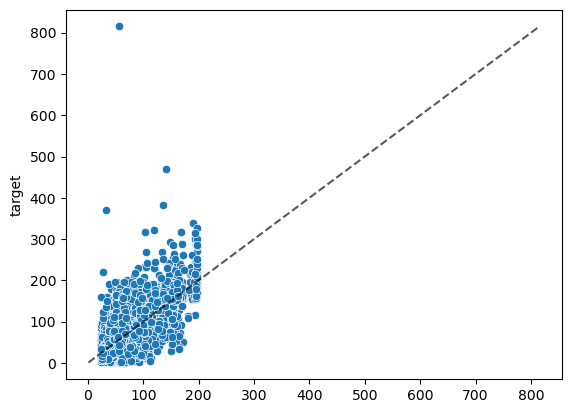

In [135]:
fig, ax = plt.subplots(1,1)
sns.scatterplot(x=y_pred, y=y_test, ax=ax)
mini = min([min(y_pred), min(y_test)])
maxi = max([max(y_pred), max(y_test)])
ax.plot(np.linspace(mini, maxi, 2), np.linspace(mini, maxi, 2), 'k--', alpha=0.65)

In [136]:
df_res = pd.DataFrame({"y_pred": y_pred, "y_test": y_test})
df_res

,y_pred,y_test
24141,62.342570,79.0
26865,123.025000,129.0
22772,41.765341,72.0
25624,88.826585,34.0
21690,66.251773,61.0
...,...,...
7201,24.784481,17.0
19407,27.419895,25.0
19609,54.501480,63.0
26644,24.322825,34.0
